In [1]:
from datetime import datetime
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn as sns
from pulp import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Datos

## datos modelos

In [2]:
datos_completos = pd.read_csv('datos/ubicaciones.csv')
coordenadas = datos_completos[['lon', 'lat']].values
datos_completos.head()

,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon
0,1,A1,1,2.0,20.506052,-98.212377
1,2,A1,1,17.0,20.458128,-98.221248
2,3,A1,1,2.0,20.530427,-98.236860
3,4,A1,3,15.0,20.488655,-98.202940
4,5,A1,1,2.0,20.533253,-98.219669


# Clusterización

## Kmeans

In [3]:
scaler = StandardScaler()
X_geo = datos_completos[['lon', 'lat']].copy()
clus_km = KMeans(n_clusters=6, random_state=42, )
clus_km.fit(scaler.fit_transform(X_geo))
D_centros_km = pairwise_distances(scaler.transform(coordenadas), clus_km.cluster_centers_, metric='euclidean')
X_geo['cluster'] = clus_km.labels_
X_geo['freq'] = datos_completos['Frecuencia']

## Knn

In [4]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(scaler.transform(X_geo[['lon', 'lat']]), X_geo['cluster'])
X_geo['nn'] = knn.predict(scaler.transform(X_geo[['lon', 'lat']]))

centros_knn = X_geo.groupby('nn')[['lon', 'lat']].mean().apply(tuple, axis=1).tolist()
D_centros_knn = pairwise_distances(scaler.transform(coordenadas), scaler.transform(centros_knn), metric='euclidean')

# Modelo LP

## variables

In [5]:
# Matriz de distancias entre todos los puntos
D = pairwise_distances(coordenadas, coordenadas, metric='euclidean')
# dias
dias = list(range(1, 7))
# Clientes
C = datos_completos['Id_Cliente'].values
# Frecuencias
F = datos_completos['Frecuencia'].values
# Volumen
V = datos_completos['Vol_Entrega'].values
# Promedios
V_mean = round((V * F).sum() / 6)
S_mean = round(F.sum() / 6)
epsilon = round(0.01 * V_mean) # Margen con respecto al promedio del volumen por dia
delta = round(0.02 * S_mean) # Margen con respecto al promedio de paradas por dia
epsilon, delta

(91, 13)

## modelo

In [6]:
ini = time.time()
# Initialize Class
model = LpProblem("Optimizacion distancias", LpMinimize)
# Define Decision Variables
z = LpVariable.dicts("visita", [(d, c) for d in dias for c in C], cat='Binary')

# Define objective function
# Minimiza la distancia de la tienda i con respecto a todas las demás tiendas del día d
model += lpSum([(z[(d, c1)]) * (D[c1-1, X_geo['nn'] == d-1]).mean() for d in dias for c1 in C])
# Satisfacción de la restricción del número de visitas
for c in C:
    model += lpSum([z[(d, c)] for d in dias]) == F[c-1]

# condiciones de balanceo del volumen
for d in dias:
    model += lpSum([z[(d, c)] * V[c-1] for c in C]) <= (V_mean + epsilon)
    model += lpSum([z[(d, c) ] * V[c-1] for c in C]) >= (V_mean - epsilon)
    
# condiciones de balanceo del numero de paradas
for d in dias:
    model += lpSum([z[(d, c)] for c in C]) <= (S_mean + delta)
    model += lpSum([z[(d, c)] for c in C]) >= (S_mean -delta)
    
# resuelve 🤞🏾
print('Resolviendo...')
model.solve()
print('¡Resuelto!')
print('Status', model.status)
print('Valor objetivo', pulp.value(model.objective))
fin = time.time()
print('tiempo:', (fin-ini) / 60, 'minutos')

D:\Anaconda\envs\urbanpy\lib\site-packages\pulp\pulp.py:1198: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Resolviendo...
¡Resuelto!
Status 1
Valor objetivo 119.01156733705835
tiempo: 0.3639644026756287 minutos


## resultados

In [12]:
# exporta resultados
resultados = [[z[(d, c)].varValue for d in dias] for c in C]
nombre_columnas = ['Id_Cliente', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6']
completo = pd.DataFrame()
completo['Id_Cliente'] = datos_completos['Id_Cliente']
completo.loc[:, nombre_columnas[1:]] = pd.DataFrame(resultados, columns=nombre_columnas[1:])
completo = completo[nombre_columnas]
fecha = datetime.now().isoformat()[:17].replace(':', '')
completo.to_csv(f'datos/completo_kmeans_{fecha}.csv', encoding='utf8', index=False)
completo.head()

,Id_Cliente,D1,D2,D3,D4,D5,D6
0,1,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,0.0,0.0,1.0,1.0
4,5,0.0,0.0,0.0,0.0,0.0,1.0


## Evaluación

In [13]:
df_comp = pd.concat([datos_completos, completo[nombre_columnas[1:]]], axis=1)
vars_volumen = []
for d in dias:
    df_comp[f'V{d}'] = df_comp[f'D{d}'].mul(df_comp['Vol_Entrega'])
    vars_volumen.append(f'V{d}')

In [14]:
# Distancia con respecto a centroides
distancias_d = dict()
for d in dias:
    C_d = df_comp.query(f'D{d}==1')['Id_Cliente'].values
    distancias_d[d] = sum([D_centros_km[c1-1, d-1] for c1 in C_d for d in dias])
    
distancias_d

{1: 5876.231613535786,
 2: 7549.040008867758,
 3: 8093.600599249104,
 4: 5835.163320612757,
 5: 6737.057179122453,
 6: 6441.408279171995}

In [15]:
# Distancia total
sum(distancias_d.values())

40532.501000559845

In [16]:
# Distancia con respecto a los demás
distancias_d = dict()
for d in dias:
    C_d = df_comp.query(f'D{d}==1')['Id_Cliente'].values
    distancias_d[d] = sum([D[c1-1, c2-1] for c1 in C_d for c2 in C_d])
    
distancias_d

{1: 14736.908043217254,
 2: 12257.708200186626,
 3: 14473.459673566345,
 4: 13905.927720255331,
 5: 11899.613294040262,
 6: 15312.724459235777}

In [17]:
sum(distancias_d.values())

82586.34139050159

In [18]:
# Número de paradas por día
df_comp[nombre_columnas[1:]].sum()

D1    675.0
D2    670.0
D3    650.0
D4    655.0
D5    651.0
D6    676.0
dtype: float64

In [19]:
# Balanceo de paradas
df_comp[nombre_columnas[1:]].sum().std()

12.15593133686871

In [20]:
# Volumen por día
df_comp[vars_volumen].sum()

V1    9158.000000
V2    8976.000000
V3    9155.666667
V4    8976.333333
V5    9158.000000
V6    8976.000000
dtype: float64

In [21]:
# Balanceo de volumen
df_comp[vars_volumen].sum().std()

99.20237452186507

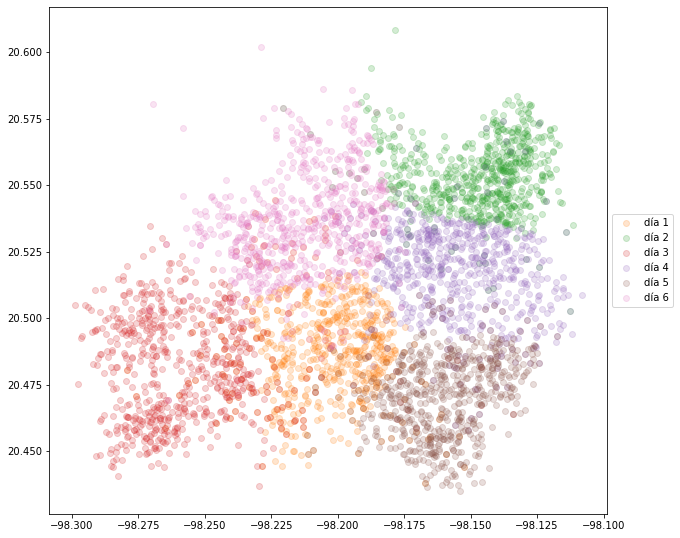

In [22]:
ax = plt.subplot()
ax.figure.set_size_inches(10, 10)
for d in dias:
    ax.scatter(y='lat', x='lon', alpha=0.2, data=df_comp.query(f'D{d}==1'), color=f'C{d}', label=f'día {d}')
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Matriz distancias

matriz_d = pd.DataFrame(D)\
    .unstack().reset_index().query('level_0<level_1')\
    .rename(columns={'level_0': 'p1', 'level_1':'p2', 0: 'dist'})\
    .eval('p1=p1 + 1')\
    .eval('p2=p2 + 1')
matriz_d.to_csv('datos/matriz_distancias_tiendas.csv', index=False)